Plots the daily AWAP data for a region over all years

In [1]:

#from __future__ import division
import numpy as np
import netCDF4 as nc
import sys
import os
import xarray
import common_functions as cf
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set(style="white", color_codes=True)


Details for the different case studies

Black Saturday

In [ ]:
# Location
latN=-38.84473
latX=-35.62343
lonN=142.5709
lonX=147.0438

# Relevant Summer Season
summer = 2008
slabel = 'October 2008 to March 2009'

# Heatwave dates
hwdates = ['28-01', '31-01', '06-02', '08-02']

pfx = 'BlackSaturday'

Brisbane Strongly Adiabatic

In [ ]:
# Location
latN=-29.12258
latX=-24.88889
lonN=151.3253
lonX=156.0329

# Relevant Summer Season
summer = 2002
slabel = 'October 2002 to March 2003'

# Heatwave dates
hwdates = ['30-11', '07-12']

pfx = 'BrisbaneAdiabatic'

Brisbane Diabatic

In [ ]:
# Location
latN=-29.12258
latX=-24.88889
lonN=151.3253
lonX=156.0329

# Relevant Summer Season
summer = 1997
slabel = 'October 1997 to March 1998'

# Heatwave dates
hwdates = ['15-12', '25-12']

pfx = 'BrisbaneDiabatic'

Melbourne

In [ ]:
# Location
latN=-38.38544
latX=-35.6777
lonN=143.0714
lonX=147.6181

# Relevant Summer Season
summer = 1999
slabel = 'October 1999 to March 2000'

# Heatwave dates
hwdates = ['08-02', '10-02']

pfx = 'Melbourne'

Perth

In [2]:
# Location
latN=-33.9799
latX=-29.21915
lonN=114.3824
lonX=118.6514

# Relevant Summer Season
summer = 2000
slabel = 'October 2000 to March 2001'

# Heatwave dates
hwdates = ['24-12', '28-12']

pfx = 'Perth'

User input arguments

In [3]:

datadir='/g/data/w97/azh561/irrigation/code/windowsearch/preprocessing/AWAP_0.05/'
syr = 1911
fyr = 2016
nyrs = fyr - syr


Define the region to focus on

In [4]:

latlonfile = nc.Dataset('%s/tmax/tmax_2010_01.nc' %(datadir),'r')
lat1d = latlonfile.variables['lat']
lon1d = latlonfile.variables['lon']
lon2d,lat2d = np.meshgrid(lon1d,lat1d)

bbox = [lonN,lonX, latN, latX]
i0,i1,j0,j1 = cf.bbox2ij(lon2d,lat2d,bbox)


Read in the data

In [5]:
y1 = syr
y2 = syr + 1
# loop through the summer seasons
var = 'tmin'
for yy in range(nyrs):
    
    # Read relevant summer season files
    var = 'tmax'
    files = nc.MFDataset(['%s/%s/%s_%s_10.nc' %(datadir,var,var,y1),'%s/%s/%s_%s_11.nc' %(datadir,var,var,y1),'%s/%s/%s_%s_12.nc' %(datadir,var,var,y1),
                          '%s/%s/%s_%s_01.nc' %(datadir,var,var,y2),'%s/%s/%s_%s_02.nc' %(datadir,var,var,y2),'%s/%s/%s_%s_03.nc' %(datadir,var,var,y2)])
    txdata = files.variables[var][:182,j0:j1,i0:i1]
    files.close()

    var = 'tmin'
    files = nc.MFDataset(['%s/%s/%s_%s_10.nc' %(datadir,var,var,y1),'%s/%s/%s_%s_11.nc' %(datadir,var,var,y1),'%s/%s/%s_%s_12.nc' %(datadir,var,var,y1),
                          '%s/%s/%s_%s_01.nc' %(datadir,var,var,y2),'%s/%s/%s_%s_02.nc' %(datadir,var,var,y2),'%s/%s/%s_%s_03.nc' %(datadir,var,var,y2)])
    tndata = files.variables[var][:182,j0:j1,i0:i1]
    files.close()
    
    tavdata = (txdata + tndata)/2

    if yy == 0:
        tav = np.empty((nyrs,182),dtype=np.float64)
        tmx = np.empty((nyrs,182),dtype=np.float64)
        tmn = np.empty((nyrs,182),dtype=np.float64)
        
    tmx[yy,:] = np.nanmean(txdata,axis=(1,2))
    tmn[yy,:] = np.nanmean(tndata,axis=(1,2))
    tav[yy,:] = np.nanmean(tavdata,axis=(1,2))
    
    y1 = y1 + 1
    y2 = y2 + 1
    
    del txdata, tndata, tavdata
        

Set up time axis

In [6]:
start = dt.datetime(2001,10,1,0,0)
end = dt.datetime(2002,3,31,0,0)
diff = end - start
days, seconds = diff.days, diff.seconds
hours = days * 24 + seconds // 3600
minutes = (seconds % 3600) // 60
seconds = seconds % 60
datelist = [start + dt.timedelta(days=x) for x in range(days+1)]
monthdaylist = np.asarray([datelist[x].strftime("%d-%m") for x in range(days+1)]) # Get the day-month

In [7]:

yarr = np.arange(syr,fyr,1)
ysummer = [i for i in range(len(yarr)) if yarr[i] == summer]
y1980 = [i for i in range(len(yarr)) if yarr[i] == 1980]
y2010 = [i for i in range(len(yarr)) if yarr[i] == 2010]
hwind = [i for i in range(len(monthdaylist)) if monthdaylist[i] in hwdates]


Plot a simple time series

Maximum Daily Temperature

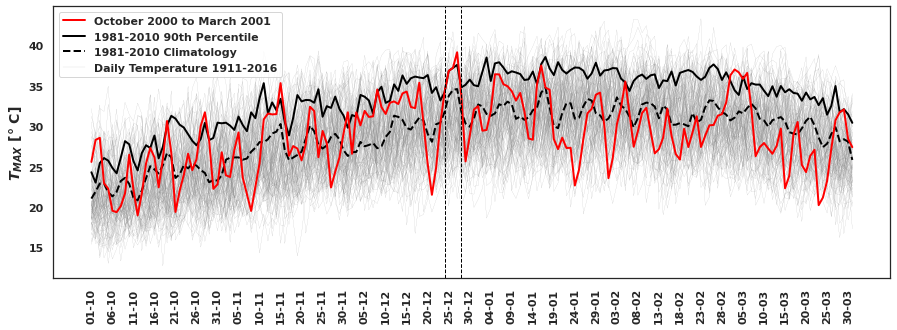

In [8]:
# Figure formatting
plt.rcParams['savefig.dpi']=1000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Create figure object and subplots
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# Plot each warm season as a separate grey line
for yy in range(nyrs):
    if yy == 0:
        ax.plot(monthdaylist,(tmx[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1, label='Daily Temperature 1911-2016')
    else:
        ax.plot(monthdaylist,(tmx[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1)

# Add lines denoting the summer season of interest, 90th percentile and the climatologu
ax.plot(monthdaylist,np.nanmean((tmx[ysummer[0]:y2010[0]+1,:]-273.15),axis=0),color='black',linestyle='--', linewidth=2.0, label='1981-2010 Climatology')
ax.plot(monthdaylist,np.nanpercentile((tmx[y1980[0]:y2010[0]+1,:]-273.15),90,axis=0),color='black',linestyle='-', linewidth=2.0, label='1981-2010 90th Percentile')
ax.plot(monthdaylist,(tmx[ysummer[0],:]-273.15),color='red',linestyle='-', linewidth=2.0, label=slabel)

# Add vertical lines to indicate the heatwave start and end dates 
for hw in range(len(hwind)):
    ax.axvline(hwind[hw], color='black', linestyle='--',linewidth=1.0)
    
# Neaten up the axes
#ax.set_ylim(5,45)
ax.set_ylabel('$T_{MAX}$ [\xb0 C]', fontweight = 'bold',fontsize=14)
ax.set_xticks(monthdaylist[::5])
ax.set_xticklabels(monthdaylist[::5], rotation=90)

# Add legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.savefig('AWAP_tmx_%s.png' %(pfx), dpi=300)


In [ ]:
np.nanmax(tmx)-273.15

In [ ]:
tmx[y2008,hw678feb]-273.15

Daily Minimum Temperature

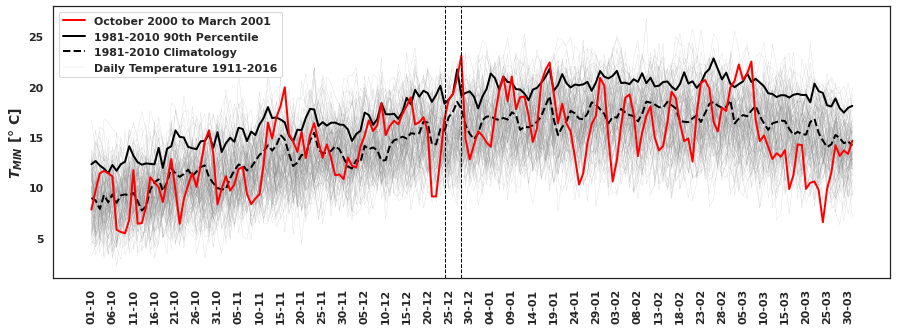

In [9]:
# Figure formatting
plt.rcParams['savefig.dpi']=1000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Create figure object and subplots
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# Plot each warm season as a separate grey line
for yy in range(nyrs):
    if yy == 0:
        ax.plot(monthdaylist,(tmn[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1, label='Daily Temperature 1911-2016')
    else:
        ax.plot(monthdaylist,(tmn[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1)

# Add lines denoting the summer season of interest, 90th percentile and the climatologu
ax.plot(monthdaylist,np.nanmean((tmn[ysummer[0]:y2010[0]+1,:]-273.15),axis=0),color='black',linestyle='--', linewidth=2.0, label='1981-2010 Climatology')
ax.plot(monthdaylist,np.nanpercentile((tmn[y1980[0]:y2010[0]+1,:]-273.15),90,axis=0),color='black',linestyle='-', linewidth=2.0, label='1981-2010 90th Percentile')
ax.plot(monthdaylist,(tmn[ysummer[0],:]-273.15),color='red',linestyle='-', linewidth=2.0, label=slabel)

# Add vertical lines to indicate the heatwave start and end dates 
for hw in range(len(hwind)):
    ax.axvline(hwind[hw], color='black', linestyle='--',linewidth=1.0)

# Neaten up the axes
#ax.set_ylim(-1,25)
ax.set_ylabel('$T_{MIN}$ [\xb0 C]', fontweight = 'bold',fontsize=14)
ax.set_xticks(monthdaylist[::5])
ax.set_xticklabels(monthdaylist[::5], rotation=90)

# Add legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.savefig('AWAP_tmn_%s.png' %(pfx), dpi=300)


Daily Average Temperature

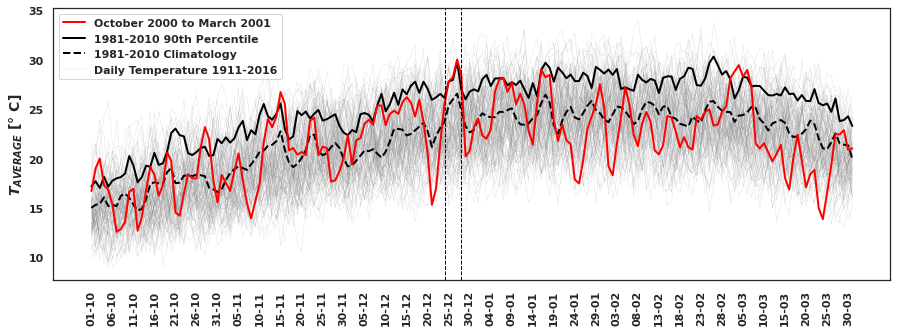

In [10]:
# Figure formatting
plt.rcParams['savefig.dpi']=1000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Create figure object and subplots
fig, ax = plt.subplots(1, 1, figsize=(15,5))

# Plot each warm season as a separate grey line
for yy in range(nyrs):
    if yy == 0:
        ax.plot(monthdaylist,(tav[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1, label='Daily Temperature 1911-2016')
    else:
        ax.plot(monthdaylist,(tav[yy,:]-273.15),color='grey',linestyle='-', linewidth=0.1)

# Add lines denoting the summer season of interest, 90th percentile and the climatologu
ax.plot(monthdaylist,np.nanmean((tav[ysummer[0]:y2010[0]+1,:]-273.15),axis=0),color='black',linestyle='--', linewidth=2.0, label='1981-2010 Climatology')
ax.plot(monthdaylist,np.nanpercentile((tav[y1980[0]:y2010[0]+1,:]-273.15),90,axis=0),color='black',linestyle='-', linewidth=2.0, label='1981-2010 90th Percentile')
ax.plot(monthdaylist,(tav[ysummer[0],:]-273.15),color='red',linestyle='-', linewidth=2.0, label=slabel)

# Add vertical lines to indicate the heatwave start and end dates 
for hw in range(len(hwind)):
    ax.axvline(hwind[hw], color='black', linestyle='--',linewidth=1.0)

# Neaten up the axes
#ax.set_ylim(5,35)
ax.set_ylabel('$T_{AVERAGE}$ [\xb0 C]', fontweight = 'bold',fontsize=14)
ax.set_xticks(monthdaylist[::5])
ax.set_xticklabels(monthdaylist[::5], rotation=90)

# Add legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc='upper left')

plt.savefig('AWAP_t2m_%s.png' %(pfx), dpi=300)
